# Why is the college acceptance yield rate lower for women?

*This is a personal project I started to help me tie together general python usage, web scraping with BeautifulSoup, data extraction with regular expressions, data manipulation with pandas, writing functions to perform hypothesis testing, building linear regression models from scratch, basic machine learning, and more. I greatly appreciate any feedback!*

---

# Part 1: University admissions and the yield rate

In my previous work running the education startup Newton China, I frequently ended up using the website [CollegeData.com](www.collegedata.com) as a reference - it lists a ton of data for a lot of schools.

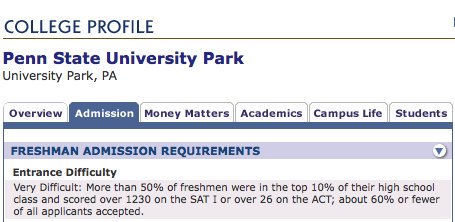

As an example, searching my alma mater brings up [Penn State's page](https://www.collegedata.com/cs/data/college/college_pg02_tmpl.jhtml?schoolId=59), which is actually one six seperate CollegeData pages of information: Overview, Admission, Money Matters, Academics, Campus Life, and Students.

Scrolling down, you'll find a bunch of numbers organized in somewhat regularly into rows. Some table rows, like `Average GPA`, are easy enough, containing only one value. But others, like the row labeled `Students Enrolled` contain three pieces of data. 

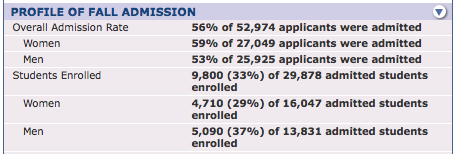

The first number in `'Students Enrolled'` is the straightforward number of students enrolled, presumably 9,800 students attending school in the fall as incoming freshmen. The third number - 29,878 - is the number of students who were offered admission. The second number - 33% - is called the **yield rate**, and it is the number that raised questions that inspired me to collect and analyze this data.


---

## But why care about the yield rate?

The yield rate is the percentage of offered students who actually enrolled and it is of considerable importance to many college admissions departments. If the admissions department enrolls too few students, the school will not receive enough tuition to cover its costs. If it enrolls too many students, the extra students will bring dorms and classrooms beyond capacity. 

Not every student who is given an offer letter - a letter of acceptance - will accept it. In fact it seems only 33% of the Penn State's offer letters were accepted. Presumably, the other 67% of students who were offered elected to attend another school. If this 33% yield rate is relatively consistent year to year, which it normally is, the school will have a good idea how many offer letters should be given out so they may end up with the right yield.

Curiously, the yield rate at Penn State for men (37%) seems a good amount higher than that for women (29%). Men seem more likely to accept Penn State's offers than women are. After looking at a few other schools' yield rates, I became curious if there actually is a significant disparity in yield rate among schools - and if so, how is this disparity distributed and what factors may predict it?


---

## Scraping collegedata.com

The collegedata.com url for Penn State's Admission information page looks like this:
`https://www.collegedata.com/cs/data/college/college_pg02_tmpl.jhtml?schoolId=59`

The `59` at the end of the URL is the `schoolId`. The `02` part of the URL indicates you are on the `'Admission'` information page. Not every `schoolId` corresponds to a school, but most do, especially in the lower range of numbers. Attempting to access a page for a number with no school will load a default page with the title `"Retrieve a Saved Search"`. After poking around a bit, I found at larger `schoolId`, especially over 1000, real school pages became more sparse, and I'm fairly confident there are no schools listed with a `schoolId` over 5000.

In order to determine if the yield disparity is real, I only need to scrape the yield rate from each page. But grabbing as much other data as possible from the six collegedata.com pages of information for each school at the same time could prove useful later when trying to find predictors for yield rate. 

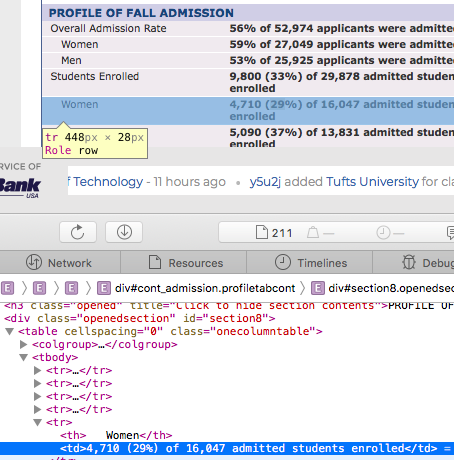

I decided a good balance would be to only get the data in the `<td>` tags under the heading `'Profile of Fall Admission'`, identified as `<div id='section8'>` in the HTML, in addition to the school's name and its location. I can always come back to scrape more if I need it in the future.

## Building a BeautifulSoup scraper

I used the wonderful [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library to help me get what I need from CollegeData's pages. It maps the HTML into a tree that can be descended down (and up) and side to side to access the elements and strings you want. 

The string `'schoolname'` is conveniently located in the first `<h1>` tag. The `'location'` is a bit more difficult to grab, as it isn't nested inside a unique tag, but can be found easily by using the search feature to find the text `'City, State, Zip'` and going from there.


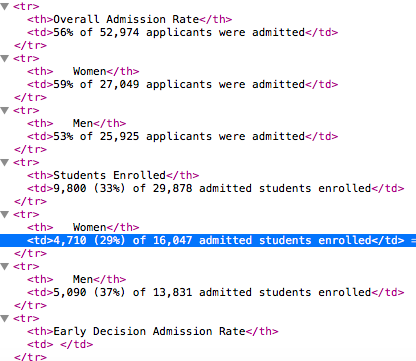

Finding `'section8'` is no problem, from there a relatively simple for loop through all of its `<tr>` descendants, each of which may have a `<th>` child to be used as a key and a `<td>` child to be used as a value. Though most of the `<th>` values are unique, some are not, including `'Women'`,`'Men'`, and the SAT Score information further down the section. 

In [64]:
from bs4 import BeautifulSoup
from requests import get

# This is the "Overview" page.
BASE_URL_1 = \
"http://www.collegedata.com/cs/data/college/college_pg01_tmpl.jhtml?schoolId="
page1_labels = {'control_type':'Institution Type',
                'coed_type':'Coeducational',
                'ugrads':'Undergraduate Students',
                'ugrads_women':'Women',
                'ugrads_men':'Men',
                'grads':'Graduate Students',
                'gpa':'Average GPA',
                'sat':'SAT Math',
                'cost':'Cost of Attendance',
                'need_met_pct':'Average Percent of Need Met',
                'award':'Average Freshman Award',
                'debt':'Average Indebtedness of 2016 Graduates',
                'on_campus_pct':'Students in College Housing'}

# This is the "Admissions" page.
BASE_URL_2 = \
"http://www.collegedata.com/cs/data/college/college_pg02_tmpl.jhtml?schoolId="
page2_labels = {'adm_rate':'Overall Admission Rate',
                'adm_women':'Women',
                'adm_men':'Men',
                'enrolled':'Students Enrolled',
                'enrolled_women':'Women*',
                'enrolled_men':'Men*',
                'ed_rate':'Early Decision Admission Rate',
                'ea_rate':'Early Action Admission Rate',
                'hs_rank':'High School Class Rank'}

# This is the "Students" page.
BASE_URL_6 = \
"http://www.collegedata.com/cs/data/college/college_pg06_tmpl.jhtml?schoolId="
page6_labels = {'ugrads_fulltime':'Full-Time Undergraduates',
                'returning_pct':'First-Year Students Returning',
                'grad_6_yrs_pct':'Students Graduating Within 6 Years'}

def scrape_page(page, labels):
    scraped = {}
    scraped['name'] = page.h1.string
    
    all_th_tags = {}
    for th_tag in page.find_all('th'):
        th_string = " ".join(string for string in th_tag.stripped_strings)
        while th_string in all_th_tags.keys():
            th_string += "*"
        all_th_tags[th_string] = th_tag
        
    for key, label in labels.items():
        th_tag = all_th_tags[label]
        td_tag = th_tag.next_sibling
        td_string = " ".join(string for string in td_tag.stripped_strings)
        scraped[key] = td_string
        
    return scraped

school_id = 59

url1 = BASE_URL_1 + str(school_id)
url2 = BASE_URL_2 + str(school_id)
url6 = BASE_URL_6 + str(school_id)

response1 = get(url1)
response2 = get(url2)
response6 = get(url6)
page1 = BeautifulSoup(response1.text, "lxml")
page2 = BeautifulSoup(response2.text, "lxml")
page6 = BeautifulSoup(response6.text, "lxml")

results = scrape_page(page1, page1_labels)
results.update(scrape_page(page2, page2_labels))
results.update(scrape_page(page6, page6_labels))

results

{'adm_men': '46% of 27,844 applicants were admitted',
 'adm_rate': '50% of 56,114 applicants were admitted',
 'adm_women': '54% of 28,270 applicants were admitted',
 'award': '$9,620',
 'coed_type': 'Yes',
 'control_type': 'Public',
 'cost': 'In-state: $36,344 Out-of-state: $51,572',
 'debt': '$37,307',
 'ea_rate': '',
 'ed_rate': '',
 'enrolled': '9,479 (34%) of 28,233 admitted students enrolled',
 'enrolled_men': '4,840 (37%) of 12,933 admitted students enrolled',
 'enrolled_women': '4,639 (30%) of 15,300 admitted students enrolled',
 'gpa': '3.58',
 'grad_6_yrs_pct': '84.9%',
 'grads': '6,284',
 'hs_rank': 'Top tenth:   35% Top quarter:   73% Top half:   96%',
 'name': 'Penn State University Park',
 'need_met_pct': '64%',
 'on_campus_pct': '35% of all students',
 'returning_pct': '93.1%',
 'sat': '629 average 580-680 range of middle 50%',
 'ugrads': '40,835',
 'ugrads_fulltime': '39,785',
 'ugrads_men': '21,761 (53.3%)',
 'ugrads_women': '19,074 (46.7%)'}

In [10]:
from bs4 import BeautifulSoup

# We need to scrape data from Page 1 ("Overview") and Page 2 ("Admissions")

page1_headers = ['Institution Type',
                 'Coeducational',
                 'Undergraduate Students',
                 'Women',
                 'Men',
                 'Graduate Students',
                 'Average GPA',
                 'SAT Math',
                 'Cost of Attendance',
                 'Average Percent of Need Met',
                 'Average Freshman Award',
                 'Average Indebtedness of 2016 Graduates',
                 'Students in College Housing',
                 'Ethnicity of Students from U.S.',
                 'International Students',
                 'First-Year Students Returning',
                 'Students Graduating Within 4 Years']

# From page 2, need section 6 and section 8

page_1_section_ids = ['']
page_2_section_ids = ['section6','section8']

def scrape_page(response, section_ids, EMPTY_TITLE = "Retrieve a Saved Search"):
    # response is from requests.get()
            
    page = BeautifulSoup(response.text, "lxml")
    
    if page.h1 is None or page.h1.string == REJECT_PAGE_TITLE:
        
        return None

    else:        
        scraped = {}        
        scraped['schoolname'] = page.h1.string
        scraped['location'] = \
                page.find('th', text="City, State, Zip").next_sibling.string
        
        for tag in page.find(id="section8").descendants:
            
            if tag.name == 'tr' and tag.th is not None and tag.td is not None:
                key = " ".join(string for string in tag.th.stripped_strings)
                val = " ".join(string for string in tag.td.stripped_strings)
                
                # If duplicate <th> headers, append asterisks until unique.
                while key in scraped:
                    key += "*"
                
                scraped[key] = val
                
        return scraped

An empty dictionary `'scraped'` is created to hold our scraped values. We add `'schoolname'` and `'location'` before looping through `id=section8`, saving every non-empty pair of `<th>` and `<td>`.  To avoid duplicates, we add a `'*'` to the key as a temporary marker until we can later clean up the key names. Finally, a `'scraped'` dictionary is returned to the caller.

---

## Requesting 5000 pages!

I've read how to implement methods to evade anti-scraping measures, but I encountered no push back from CollegeData when making these basic requests. It took me about 40 minutes to run through this loop.

In [14]:
from requests import get
from IPython.core.display import clear_output
from warnings import warn

# This is the "Overview" page.
BASE_URL_1 = \
"http://www.collegedata.com/cs/data/college/college_pg01_tmpl.jhtml?schoolId="

# This is the "Admissions" page.
BASE_URL_2 = \
"http://www.collegedata.com/cs/data/college/college_pg02_tmpl.jhtml?schoolId="

# Start and stop page IDs to append to the base URLs.
START_ID = 0
END_ID = 5000



scraped_pages = {}
    
for schoolId in range(START_ID, END_ID+1):
    
    url = BASE_URL_2 + str(schoolId) 
    
    print(url)   # Print a status update.
    
    response = get(url)
    
    if response.status_code != 200:
        warn('Request {} caused status code {}.'.format(schoolId, 
                                                        response.status_code))
    
    scraped = scrape(response)
    
    if scraped:
        scraped_pages[schoolId] = scraped
        
    clear_output(wait = True) # clear the status update

print('Requested schoolId {} to {}, scraping {} pages.'.format(START_ID, END_ID, len(scraped_pages)))

Requested schoolId 4000 to 5000, scraping 0 pages.


We now have a dictionary, `'scraped_pages'`, filled with keys `'schoolId'` associated with scraped dictionaries, which themselves are filled with scraped `<th>` keys and `<td>` values, in addition to `'location'` and `'schoolname'`. Pandas' `'DataFrame.from_dict'` method will quickly convert this to a DataFrame, which we will then backup to .csv before moving forward.

In [3]:
import pandas as pd
college = pd.DataFrame.from_dict(scraped_pages, orient='index') # convert scraped pages to a pandas DataFrame
college.to_csv('collegedata_scraped_backup.csv')   # backup

---
## 5000 more pages

We want to get more information about the total number of undergraduates and their breakdown by gender and race, which is on a separate page. After building another scraper and scraping, we can join this to our existing dataframe.

In [29]:
import pandas as pd
from requests import get
from IPython.core.display import clear_output
from warnings import warn
from bs4 import BeautifulSoup

college = pd.read_csv('collegedata_scraped_backup.csv', index_col=0)
schoolIds = college.index.tolist()
BASE_URL = "http://www.collegedata.com/cs/data/college/college_pg06_tmpl.jhtml?schoolId="


def scrape_2(response, REJECT_PAGE_TITLE = "Retrieve a Saved Search"):
    # response is from requests.get()
            
    page = BeautifulSoup(response.text, "lxml")
    
    if page.h1 is None or page.h1.string == REJECT_PAGE_TITLE:
        
        return None

    else:        
        scraped = {}
        for tag in page.find(id="section26").descendants:
            
            if tag.name == 'tr' and tag.th is not None and tag.td is not None:
                key = " ".join(string for string in tag.th.stripped_strings)
                val = " ".join(string for string in tag.td.stripped_strings)
                
                while key in scraped:  # Temporarily deal with identical table headers cells
                    key += "*"
                
                scraped[key] = val
                
        return scraped

    
scraped_pages = {}

for schoolId in schoolIds[1748:]:
    
    url = BASE_URL + str(schoolId) 
    print(url)   # a status update
    
    response = get(url)
    
    if response.status_code != 200:
        warn('Request {} caused status code {}.'.format(schoolId, response.status_code))
    
    scraped = scrape_2(response)
    
    if scraped:
        scraped_pages[schoolId] = scraped
        
    clear_output(wait = True) # clear the status update

print('Requested schoolId {} to {}, scraping {} pages.'.format(schoolIds[0], schoolIds[-1], len(scraped_pages)))

Requested schoolId 6 to 3379, scraping 282 pages.


In [32]:
page22 = pd.DataFrame.from_dict(scraped_pages, orient='index')
page22.shape

(282, 9)

In [35]:
page1 = pd.read_csv('collegedata_scraped_backup.csv', index_col=0)
page1.shape

(2030, 53)

In [40]:
college = page1.join(page2.append(page22).rename(columns={'Women':'Undergrads (women)','Men':'Undergrads (men)'}))
college.to_csv('collegedata_scraped_backup.csv')   # backup

---

## Inspecting the results

Let's look at the results for Penn State, which was had a schoolId of 59. 

In [5]:
college.loc[59]

schoolname                                                      Penn State University Park
location                                                        University Park, PA  16802
Overall Admission Rate                              56% of 52,974 applicants were admitted
Women                                               59% of 27,049 applicants were admitted
Men                                                 53% of 25,925 applicants were admitted
Students Enrolled                         9,800 (33%) of 29,878 admitted students enrolled
Women*                                    4,710 (29%) of 16,047 admitted students enrolled
Men*                                      5,090 (37%) of 13,831 admitted students enrolled
Early Decision Admission Rate                                                          NaN
Early Action Admission Rate                                                            NaN
Students Offered Wait List                                                             NaN

In [6]:
college.shape

(1813, 53)

## But is this sample an accurate representation of all American colleges?
Our sample size is 1813 separate schools, with 53 columns scraped for each. According to the [US Dept. of Education's National Center for Education Statistics](https://nces.ed.gov/programs/digest/d12/tables/dt12_005.asp), there were 2870 4-year colleges as of 2011. It would be very helpful to know what criteria the people behind CollegeData used to add schools to their site. Are CollegeData's schools only the largest? Only those who filled out a survey? Only those who paid?

Perhaps the missing ~1000 schools that were not availble on CollegeData are all very small in size, and what we've scraped makes up a significant portion of the college population.

I'm not sure how accurately this sample represents the overall population of 4-year colleges - and how accurately insights drawn from analysis of it can be generalized to the greater population of all schools - and more investigation into CollegeData's data acquisition process is warranted. Be warned!

## Conclusion
With that said, there's not much more analysis we can do at this point. The Yield Rates values are found in the `'Students Enrolled'`, `'Women*`', and `'Men*'` labels, but they are represented as strings of text rather than pure numbers we can numerically analyze. We will have to separate and clean up these values, along with most of the other 58 fields we scraped.

Only ofter cleaning will we be able to explore this data, test if the Yield Rate disparity is real, and, if so, explore the possible predictors for this gap.